In [8]:
!apt update

Get:1 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5394 B]
Get:2 http://packages.cloud.google.com/apt cloud-sdk-bionic InRelease [6780 B] 
Get:3 http://packages.cloud.google.com/apt cloud-sdk InRelease [6739 B]        
Get:4 http://packages.cloud.google.com/apt gcsfuse-bionic/main amd64 Packages [2649 B]3m
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease                    
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://packages.cloud.google.com/apt cloud-sdk-bionic/main amd64 Packages [181 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:9 http://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [162 kB]0m
Get:10 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [24.7 kB]m
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]m  
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2119 kB]3m
Get:13

In [9]:
!apt install python3-pip -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.4).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [10]:
!pip install -q efficientnet

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import cv2
import sys
import math
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import albumentations as A
import glob
import torch
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from functools import partial
from PIL import Image
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import random
from imgaug import augmenters as iaa
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization,Lambda, GlobalAveragePooling2D, Concatenate, Lambda
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB5, EfficientNetB3, EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing import image

# fastai library for computer vision tasks
from fastai.vision.all import *

# Python library for image augmentation
import albumentations as A
from kaggle_datasets import KaggleDatasets
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/parameters/GENet_large.pth
/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv
/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json
/kaggle/input/cassava-leaf-disease-classification/train.csv
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train14-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train13-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train04-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train01-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train08-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train00-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train10-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train02-1338.tfrec
/kaggle/input/cassava-leaf-disease-classifi

In [12]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [13]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8


# 1. Load the Data

In [14]:
train_img_path = '/kaggle/input/cassava-leaf-disease-classification/train_images'
test_img_path = '/kaggle/input/cassava-leaf-disease-classification/test_images'
sub_path = '/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv'

train_file = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')

path = Path('../input/cassava-leaf-disease-classification')
MODEL_WEIGHTS_PATH = '/kaggle/input/efficientnetb3/efficientnetb3_notop.h5'
typeLeaf = open('/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json')
images = os.listdir(train_img_path)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print("Training images:", len(images))

Training images: 21397


Display the class

In [15]:
class_map = json.load(typeLeaf)
print(json.dumps(class_map,indent=1))
lis = json.dumps(class_map)

{
 "0": "Cassava Bacterial Blight (CBB)",
 "1": "Cassava Brown Streak Disease (CBSD)",
 "2": "Cassava Green Mottle (CGM)",
 "3": "Cassava Mosaic Disease (CMD)",
 "4": "Healthy"
}


In [16]:
train_file.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [17]:
labels = train_file.label.unique()
labels_number = len(labels)
print(f'Labels: {labels}')

Labels: [0 3 1 2 4]


In [18]:
train_img_path

'/kaggle/input/cassava-leaf-disease-classification/train_images'

In [19]:
test_img_path

'/kaggle/input/cassava-leaf-disease-classification/test_images'

Type of Cassava Leaf Visualization

1. Samples of "0": "Cassava Bacterial Blight (CBB)"

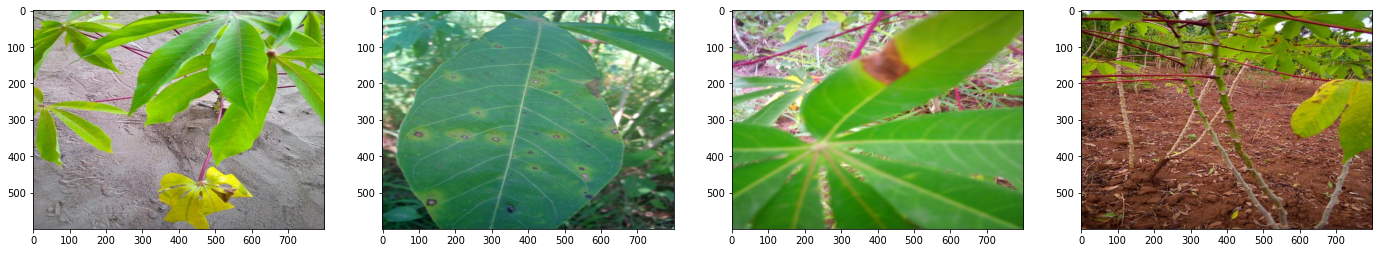

In [20]:
samples = train_file[train_file['label']==0].sample(4) #Reset index isn't necessary
samples
plt.figure(figsize=(24,16))

for i, (image_id, label) in enumerate(zip(samples.image_id, samples.label)):
    plt.subplot(1,4,i+1)
    path = os.path.join('/kaggle/input/cassava-leaf-disease-classification/train_images',image_id)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

2. Samples of "1": "Cassava Brown Streak Disease (CBSD)"

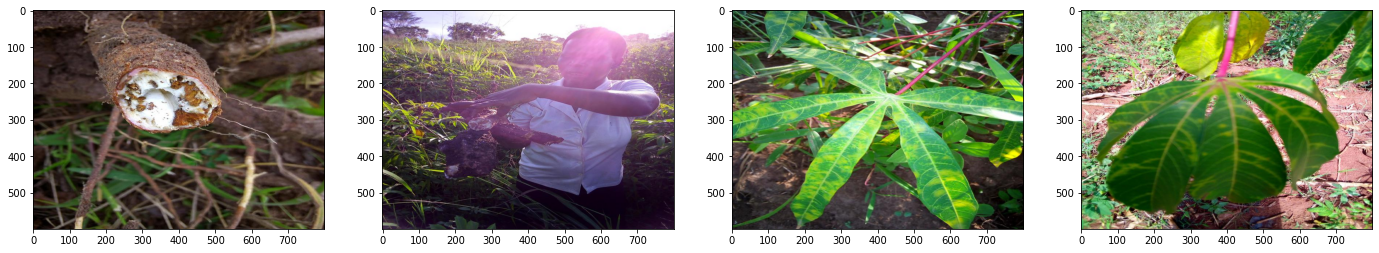

In [21]:
samples = train_file[train_file['label']==1].sample(4)

plt.figure(figsize=(24,16))

for i, (image_id, label) in enumerate(zip(samples.image_id, samples.label)):
    plt.subplot(1,4,i+1)
    path = os.path.join('/kaggle/input/cassava-leaf-disease-classification/train_images',image_id)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

3. Samples of "2": "Cassava Green Mottle (CGM)"

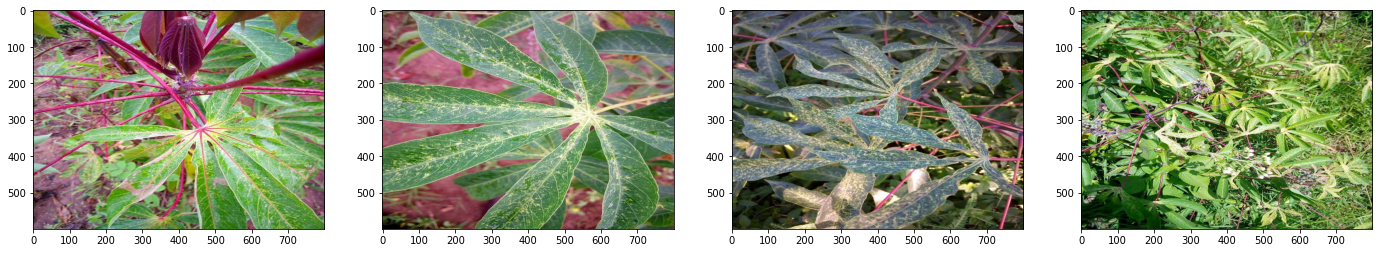

In [22]:
samples = train_file[train_file['label']==2].sample(4)

plt.figure(figsize=(24,16))

for i, (image_id, label) in enumerate(zip(samples.image_id, samples.label)):
    plt.subplot(1,4,i+1)
    path = os.path.join('/kaggle/input/cassava-leaf-disease-classification/train_images',image_id)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

4. Samples of "3": "Cassava Mosaic Disease (CMD)"

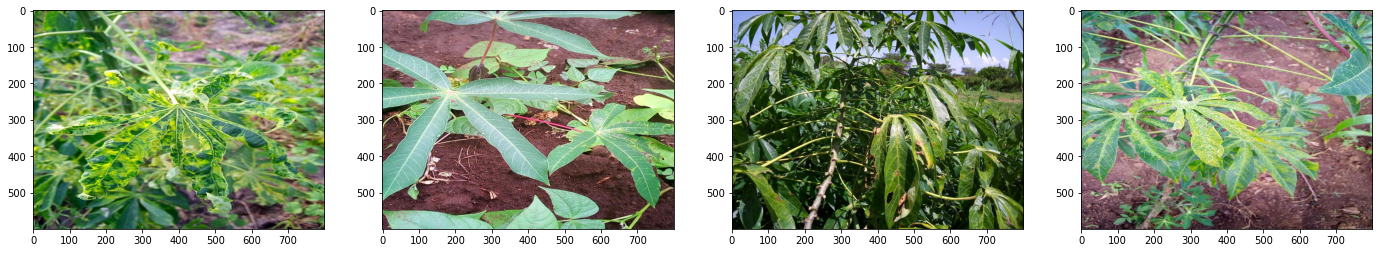

In [23]:
samples = train_file[train_file['label']==3].sample(4)

plt.figure(figsize=(24,16))

for i, (image_id, label) in enumerate(zip(samples.image_id, samples.label)):
    plt.subplot(1,4,i+1)
    path = os.path.join('/kaggle/input/cassava-leaf-disease-classification/train_images',image_id)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

5. Samples of "4": "Healthy"

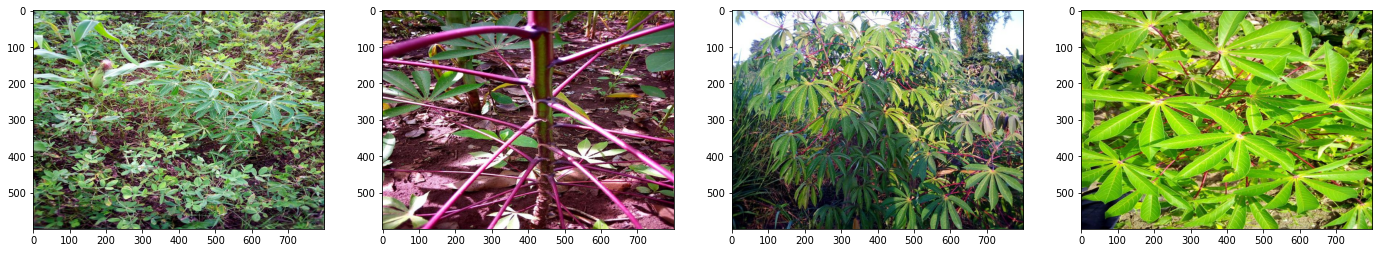

In [24]:
samples = train_file[train_file['label']==4].sample(4)

plt.figure(figsize=(24,16))

for i, (image_id, label) in enumerate(zip(samples.image_id, samples.label)):
    plt.subplot(1,4,i+1)
    path = os.path.join('/kaggle/input/cassava-leaf-disease-classification/train_images',image_id)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

Prepare the training and validation data generators

In [25]:
samples_df = shuffle(train_file, random_state=42)
samples_df["filepath"] = train_img_path+samples_df["image_id"]
samples_df[:5]

image_id  label  \
9134   2615227158.jpg      4   
1580   1277648239.jpg      3   
7304   2305895487.jpg      3   
13196   336299725.jpg      2   
5333   1951270318.jpg      2   

                                                                           filepath  
9134   /kaggle/input/cassava-leaf-disease-classification/train_images2615227158.jpg  
1580   /kaggle/input/cassava-leaf-disease-classification/train_images1277648239.jpg  
7304   /kaggle/input/cassava-leaf-disease-classification/train_images2305895487.jpg  
13196   /kaggle/input/cassava-leaf-disease-classification/train_images336299725.jpg  
5333   /kaggle/input/cassava-leaf-disease-classification/train_images1951270318.jpg

In [26]:
samples_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21397 entries, 9134 to 15795
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
 2   filepath  21397 non-null  object
dtypes: int64(1), object(2)
memory usage: 668.7+ KB


As it is a multi-class classification problem (5 classes), we will one-hot encode the target variable.

In [27]:
from kaggle_datasets import KaggleDatasets

In [28]:

SPLIT_TEST_SIZE = 0.2
IMG_SIZE = 512
BATCH_SIZE = 8
TOP_DROPOUT_RATE = 0.2
DROPOUT_RATE = 0.4
CLASSES = ['0', '1', '2', '3', '4']
classes_to_predict = sorted(samples_df.label.unique())
classes_to_predict

[0, 1, 2, 3, 4]

Applying Data Augementation Layers

In [29]:
def brighten_img(x, max_delta=0.1):
    x = tf.image.random_brightness(x, max_delta)
    return x

def brighten(max_delta=0.1):
    return layers.Lambda(lambda x: brighten_img(x, max_delta))

In [30]:
def saturate_img(x, lower=0.6, upper=1.3):
    x = tf.image.random_saturation(x, lower, upper)
    return x

def saturate(lower=0.6, upper=1.3):
    return layers.Lambda(lambda x: saturate_img(x, lower, upper))

In [31]:
data_augmentation_layers = tf.keras.Sequential(
    [
        
        layers.experimental.preprocessing.RandomCrop(height=IMG_SIZE, width=IMG_SIZE),
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.25),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2)),
        brighten(),
        saturate(),
        
    ]
)

Visualizing what our augmentation will look like on images

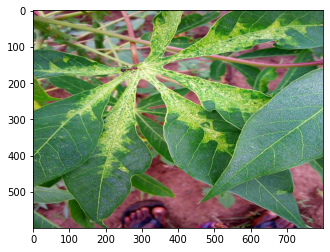

In [32]:
#image = Image.open("/kaggle/input/cassava-leaf-disease-classification/train_images/2345003518.jpg") # "0": "Cassava Bacterial Blight (CBB)",
#image = Image.open("/kaggle/input/cassava-leaf-disease-classification/train_images/3068895856.jpg") #  "1": "Cassava Brown Streak Disease (CBSD)",
#image = Image.open("/kaggle/input/cassava-leaf-disease-classification/train_images/3074332326.jpg") #  "2": "Cassava Green Mottle (CGM)",
image = Image.open("/kaggle/input/cassava-leaf-disease-classification/train_images/2584392391.jpg") #  "3": "Cassava Mosaic Disease (CMD)",
#image = Image.open("../input/cassava-leaf-disease-classification/train_images/3537938630.jpg") # "4": "Healthy"

plt.imshow(image)
plt.show()

In [33]:
image = tf.expand_dims(np.array(image), 0)

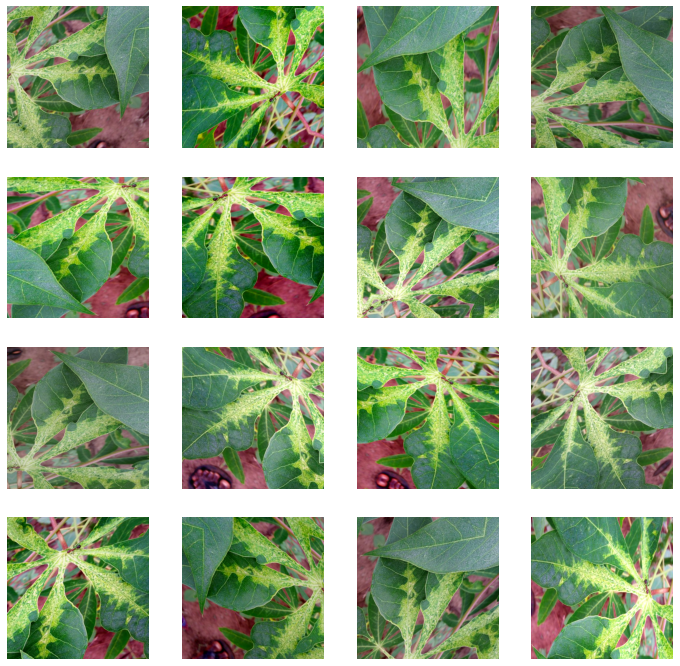

In [34]:
plt.figure(figsize=(12, 12))
for i in range(16):
  augmented_image = data_augmentation_layers(image)
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [35]:
!git clone https://github.com/idstcv/GPU-Efficient-Networks.git

Cloning into 'GPU-Efficient-Networks'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 99 (delta 48), reused 66 (delta 30), pack-reused 0
Unpacking objects: 100% (99/99), done.


In [36]:
cd ./GPU-Efficient-Networks

/kaggle/working/GPU-Efficient-Networks


In [37]:
import GENet

In [38]:
cd ../

/kaggle/working


In [39]:
path = Path('/kaggle/input/cassava-leaf-disease-classification')

In [40]:
train_file2 = pd.read_csv(path/'train.csv')
train_file2

image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]

In [41]:
train_file2['image_id'] = train_file2['image_id'].map(lambda x : path /'train_images'/x )
train_file2.head()

image_id  \
0  /kaggle/input/cassava-leaf-disease-classification/train_images/1000015157.jpg   
1  /kaggle/input/cassava-leaf-disease-classification/train_images/1000201771.jpg   
2   /kaggle/input/cassava-leaf-disease-classification/train_images/100042118.jpg   
3  /kaggle/input/cassava-leaf-disease-classification/train_images/1000723321.jpg   
4  /kaggle/input/cassava-leaf-disease-classification/train_images/1000812911.jpg   

   label  
0      0  
1      3  
2      1  
3      1  
4      3

In [42]:
# obtain the input images.
def get_x(r):
    return r['image_id']

# obtain the targets.
def get_y(r):
    return r['label']

In [43]:
'''AlbumentationsTransform will perform different transforms over both
   the training and validation datasets ''' 
class AlbumentationsTransform(RandTransform):
    
    '''split_idx is None, which allows for us to say when we're setting our split_idx.
       We set an order to 2 which means any resize operations are done first before our new transform. '''
    split_idx, order = None, 2
    
    def __init__(self, train_aug, valid_aug): store_attr()
    
    # Inherit from RandTransform, allows for us to set that split_idx in our before_call.
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    # If split_idx is 0, run the trainining augmentation, otherwise run the validation augmentation. 
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [44]:
def get_train_aug(size): 
    
    return A.Compose([
            # allows to combine RandomCrop and RandomScale
            A.RandomResizedCrop(size,size),
            
            # Transpose the input by swapping rows and columns.
            A.Transpose(p=0.5),
        
            # Flip the input horizontally around the y-axis.
            A.HorizontalFlip(p=0.5),
        
            # Flip the input horizontally around the x-axis.
            A.VerticalFlip(p=0.5),
        
            # Randomly apply affine transforms: translate, scale and rotate the input.
            A.ShiftScaleRotate(p=0.5),
        
            # Randomly change hue, saturation and value of the input image.
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        
            # Randomly change brightness and contrast of the input image.
            A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        
            # CoarseDropout of the rectangular regions in the image.
            A.CoarseDropout(p=0.5),
        
            # CoarseDropout of the square regions in the image.
            A.Cutout(p=0.5) ])

def get_valid_aug(size): 
    
    return A.Compose([
    # Crop the central part of the input.   
    A.CenterCrop(size, size, p=1.),
    
    # Resize the input to the given height and width.    
    A.Resize(size,size)], p=1.)

In [45]:
'''The first step item_tfms resizes all the images to the same size (this happens on the CPU) 
   and then batch_tfms happens on the GPU for the entire batch of images. '''
# Transforms we need to do for each image in the dataset
item_tfms = [Resize(256), AlbumentationsTransform(get_train_aug(256), get_valid_aug(256))]

# Transforms that can take place on a batch of images
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [46]:
def get_data(bs=32, data_df=train_file2):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=RandomSplitter(seed=42), # split data into training and validation subsets.
                       get_x=get_x, # obtain the input images.
                       get_y=get_y, # obtain the targets.
                       item_tfms = item_tfms,
                       batch_tfms = batch_tfms)
    return dblock.dataloaders(data_df,bs=bs)

dls = get_data()

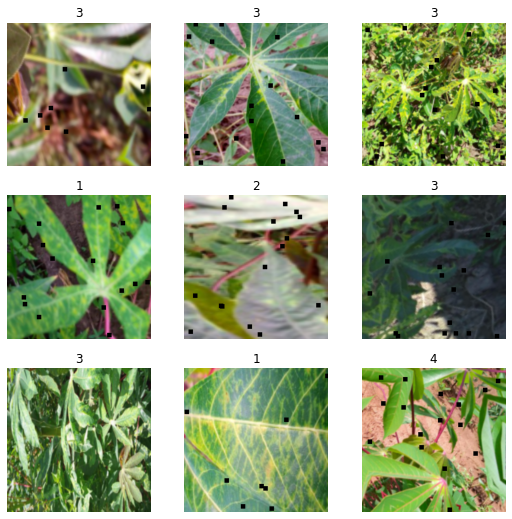

In [47]:
# We can call show_batch() to see what a sample of a batch looks like.
dls.show_batch()

In [48]:
model = GENet.genet_large(pretrained=True, root='/kaggle/input/parameters/')

In [49]:
# Group together some dls, a model, and metrics to handle training
learn = Learner(dls, model, metrics = accuracy) 

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0012022644514217973)

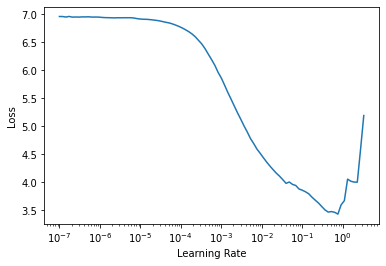

In [50]:
# Choosing a good learning rate
learn.lr_find()

In [51]:
# We can use the fine_tune function to train a model with this given learning rate
learn.fine_tune(1, base_lr=0.0012022644514217973)

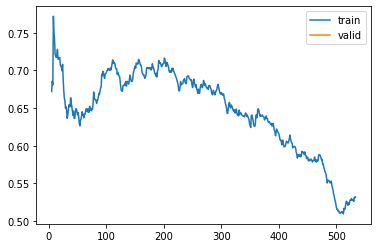

In [52]:
# Plot training and validation losses.
learn.recorder.plot_loss()

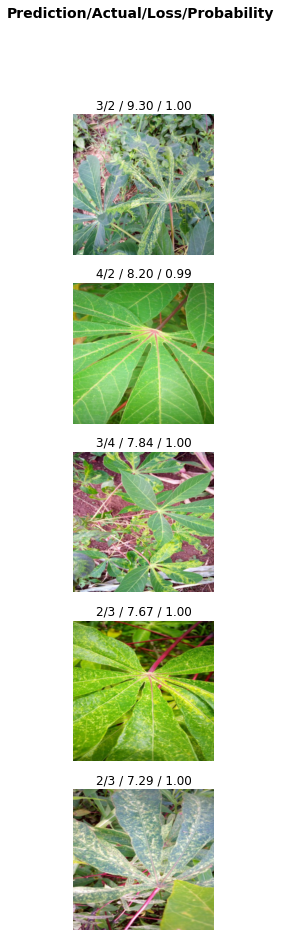

In [53]:
# Interpretation methods for classification models.
interp = ClassificationInterpretation.from_learner(learn)

# Show images in top_losses along with their prediction, actual, loss, and probability of actual class.
interp.plot_top_losses(5, nrows=5)

In [54]:
sample = pd.read_csv(path/'sample_submission.csv')
sample

image_id  label
0  2216849948.jpg      4

In [55]:
_sample = sample.copy()
_sample['image_id'] = _sample['image_id'].map(lambda x:path/'test_images'/x)
test_dl = dls.test_dl(_sample)

In [56]:
_sample.head()

image_id  \
0  /kaggle/input/cassava-leaf-disease-classification/test_images/2216849948.jpg   

   label  
0      4

In [57]:
a, _ = learn.tta(dl=test_dl, n=8)
pred = a.argmax(dim=1).numpy()
sample['label'] = pred

In [58]:
sample.to_csv('submission.csv',index=False)